# TR analysis workflow

## Perform initial filtering

In [24]:
import gzip
from collections import namedtuple
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [16.5, 5]
plt.rcParams['font.size'] = 12
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [3]:
joint_vcf = "../../../palladium-vcf/10_trgt/output/merged.vcf.gz"
passed_vcf = "output/filtered.vcf.gz"
consistent_vcf = "output/consistent.vcf.gz"
inheritance_vector_path = "/home/edolzhenko/flash/2024/Q2/palladium/000_ivecs.grch38.csv"

In [6]:
TrAllele = namedtuple("TrAllele", "seq purity meth")
Locus = namedtuple("Locus", "chrom start end")
TrRec = namedtuple("TrRec", "trid locus motifs gts")

def get_vcf_rec(vcf_path):
    with gzip.open(vcf_path, "rb") as file:
        for line in file:
            line = line.decode("ascii")
            sl = line.split()
            if line.startswith("#CHROM"):
                index = sl.index("FORMAT") + 1
                samples = sl[index:]
                continue
            if line[0] == "#":
                continue
            trid = sl[7].split(";")[0].replace("TRID=", "")
            motifs = sl[7].split(";")[-2].replace("MOTIFS=", "").split()
            chrom = sl[0]
            start = int(sl[1])
            end = int(sl[7].split(";")[1].replace("END=", ""))
            locus = Locus(chrom, start, end)
            alleles = [sl[3]]  # Start with the ref allele
            alleles.extend(sl[4].split(","))  # And then extend with alts
            alleles = [a[1:] for a in alleles] # Remove padding base
            gts = {sample: [] for sample in samples}
            for sample, rec in zip(samples, sl[9:]):
                rec = rec.split(":")
                al_idxs = [int(idx) if idx != "." else None for idx in rec[0].split("/")]
                aps = [float(val) if val != "." else None for val in rec[-2].split(",")]
                ams = [float(val) if val != "." else None for val in rec[-1].split(",")]
                for al_idx, ap, am in zip(al_idxs, aps, ams):
                    if al_idx is None:
                        break
                    seq = alleles[al_idx]
                    allele = TrAllele(seq, ap, am)
                    gts[sample].append(allele)
            yield TrRec(trid, locus, motifs, gts)

In [99]:
passed_trs = set()
total_trs = 0
num_passed = 0

for index, rec in enumerate(get_vcf_rec(joint_vcf)):
    all_alleles = []
    all_purities = []
    for sample, alleles in rec.gts.items():
        all_alleles.extend([a.seq for a in alleles])
        all_purities.extend([a.purity for a in alleles if a.purity])

    total_trs += 1

    # Skip repeats with at least one missing genotype 
    if len([gt for sample, gt in rec.gts.items() if gt]) != 10:
        continue

    # Skip repeats where at least one allele missing purity
    if len(all_alleles) != len(all_purities):
        continue

    # Skip repeats with very low purity
    if np.mean(all_purities) < 0.5:
        continue

    # Skip repeats with singleton alleles since these are
    # enriched in errors or de novos
    count_by_allele = Counter(all_alleles)
    min_count = min(count_by_allele.values())
    if min_count == 1:
        continue

    # Skip non-polymorphic repeats
    if len(count_by_allele) == 1:
        continue

    # Skip repeats with very short alleles
    longest_allele = max(len(a) for a in all_alleles)
    if longest_allele < 10:
        continue

    passed_trs.add(rec.trid)
    num_passed += 1

print(f"Num trs processed = {total_trs}; left after filtering = {num_passed}")

Num trs processed = 7722730; left after filtering = 650610


In [6]:
# Num trs processed = 7717950; left after filtering = 655692

## Generate VCF with filtered TRs

In [100]:
def subset_vcf(input_vcf, output_vcf, trids_to_keep):
    with gzip.open(input_vcf, "rb") as infile, gzip.open(output_vcf, "wb") as outfile:
            for line in infile:
                if chr(line[0]) != "#":
                    sl = line.decode("ascii").split()
                    trid = sl[7].split(";")[0].replace("TRID=", "")
                    if trid not in trids_to_keep:
                        continue
                outfile.write(line)

#subset_vcf(joint_vcf, passed_vcf, passed_trs)

## Generate a VCF file with consistent TRs

In [52]:
import importlib
import helpers.consistency as cons

importlib.reload(cons)

<module 'helpers.consistency' from '/pbi/flash/edolzhenko/2024/Q2/PlatinumPedigree/pipelines/tandem-repeats/helpers/consistency.py'>

In [53]:
ivecs = cons.load_ivecs(inheritance_vector_path)

In [54]:
def get_ivec(inheritance_vecs, locus):
    for inheritance_vec in inheritance_vecs:
        if inheritance_vec["chrom"] == locus.chrom and inheritance_vec["start"] <= locus.start and locus.end <= inheritance_vec["end"]:
            return inheritance_vec
    return None


def summarize(hap_to_dists):
    num_imperfect = 0
    max_error = 0
    total_dist = 0
    for hap, dists in hap_to_dists.items():
        if not dists:
            continue
        if max(dists) != 0:
            num_imperfect += 1
        allele_error = (len(dists) - dists.count(0)) / len(dists)
        max_error = max(max_error, allele_error)
        total_dist += sum(dists)

    return num_imperfect, max_error, total_dist

In [61]:
def get_alleles(gts):
    alleles = []
    for sample, gt in gts.items():
        alleles.extend(gt)
    return alleles


consistent_trids = set()
num_skipped = 0
with open("output/summary_table.txt", "w") as file:
    for index, rec in enumerate(get_vcf_rec(passed_vcf)):
        # TODO: Confirm that all Trs have been genotyped

        is_consistent = False
        ivec = get_ivec(ivecs, rec.locus)
        # Count loci not covered by inheritance vectors as inconsistent
        if ivec is not None:
            candidates = cons.get_candidates(ivec, rec.gts)
            assign, hap_to_dists = cons.get_best_assign(ivec, rec.gts, candidates)
            num_imperfect, max_error, total_dist = summarize(hap_to_dists)
            is_consistent = num_imperfect == 0
        if is_consistent:
            consistent_trids.add(rec.trid)

        alleles = get_alleles(rec.gts)
        lens = [len(a.seq) for a in alleles]
        purities = [a.purity for a in alleles if a.purity is not None]
        meths = [a.meth for a in alleles if a.meth is not None]
        region = f"{rec.locus.chrom}:{rec.locus.start}-{rec.locus.end}"
        motifs = ",".join(rec.motifs)
        mean_len = f"{np.mean(lens):.2f}" if len(lens) != 0 else "NA"
        mean_purity = f"{np.mean(purities):.2f}" if len(purities) != 0 else "NA"
        mean_meth = f"{np.mean(meths):.2f}" if len(meths) != 0 else "NA"
        consistent = "CONS" if is_consistent else "DISC"
        print(f"{rec.trid}\t{region}\t{motifs}\t{mean_len}\t{mean_purity}\t{mean_meth}\t{consistent}", file=file)

In [62]:
! cut -f 7 output/summary_table.txt | sort | uniq -c

 523278 CONS
 127332 DISC


In [116]:
#print(f"TRs total = {total_trs}; consistent TRs = {len(consistent_trids)}; skipped TRs: {num_skipped}")

In [75]:
#subset_vcf(passed_vcf, consistent_vcf, consistent_trids)

## Study general properties of TRs

In [30]:
plt.rc("image", cmap="Dark2")

In [31]:
TrSummary = namedtuple("TrSummary", "trid locus motifs mean_len mean_purity mean_meth is_consistent")

def get_summary_rec():
    with open("output/summary_table.txt", "r") as file:
        for line in file:
            trid, locus, motifs, mean_len, mean_purity, mean_meth, is_consistent = line.split()
            chrom, start, end = locus.replace(":", "-").split("-")
            start, end = int(start), int(end)
            locus = Locus(chrom, start, end)
            motifs = motifs.split(",")
            mean_len = float(mean_len)
            mean_purity = float(mean_purity) if mean_purity != "NA" else None
            mean_meth = float(mean_meth) if mean_meth != "NA" else None
            assert is_consistent in ["DISC", "CONS"]
            is_consistent = is_consistent == "CONS"
            yield TrSummary(trid, locus, motifs, mean_len, mean_purity, mean_meth, is_consistent)

Text(0, 0.5, 'Mean allele purity')

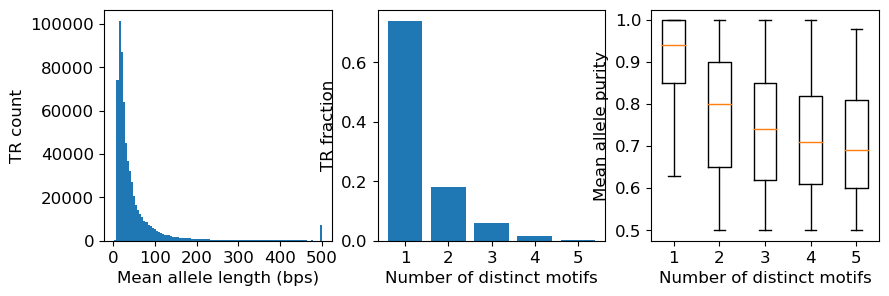

In [32]:
mean_allele_lens = []
trs_by_motif = [0 for motif in range(0, 5)]
purities_by_motif = [[] for motif in range(0, 5)]
num_composite = 0
simple_mcs = []
composite_mcs = []


for rec in get_summary_rec():
    mean_allele_lens.append(min(rec.mean_len, 500))
    num_motifs = len(rec.motifs)
    trs_by_motif[num_motifs - 1] += 1

    if num_motifs > 1:
        num_composite += 1
        composite_mcs.append(rec.mget_summary_rec()ean_len)
    else:
        simple_mcs.append(rec.mean_len)
    
    purities_by_motif[num_motifs - 1].append(rec.mean_purity)
    
    
trs_by_motif = [count / sum(trs_by_motif) for count in trs_by_motif]

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10, 3))

ax0.hist(mean_allele_lens, bins=100)
ax0.set_xlabel("Mean allele length (bps)")
ax0.set_xticks([0, 100, 200, 300, 400, 500])
ax0.set_ylabel("TR count")
ax1.bar([1, 2, 3, 4, 5], trs_by_motif)
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_xlabel("Number of distinct motifs")
ax1.set_ylabel("TR fraction")
ax2.boxplot(purities_by_motif, showfliers=False)
ax2.set_xlabel("Number of distinct motifs")
ax2.set_ylabel("Mean allele purity")

#plt.savefig("output/summary_figure/panels_a-c.pdf");

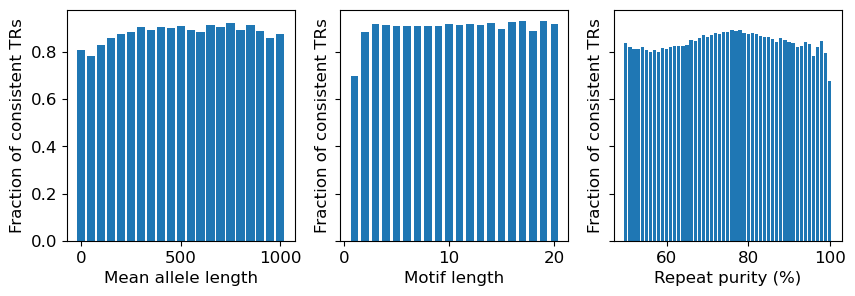

In [38]:
def plot_bars(ax, x_by_y, title_x, title_y, width):
    xs = sorted(x_by_y)
    ys = [x_by_y[x]["cons"] / x_by_y[x]["total"] for x in xs]
    ax.bar(xs, ys, width=width)
    ax.set_xlabel(title_x)
    ax.set_ylabel(title_y)


cons_by_len = {x : {"cons": 0, "total" : 0} for x in range(0, 1000 + 1, 50)}
cons_by_motif = {x : {"cons": 0, "total" : 0} for x in range(1, 20 + 1)}
cons_by_purity = {x : {"cons": 0, "total" : 0} for x in range(50, 100 + 1)}

for rec in get_summary_rec():
    #print(summary)
    mean_len = min(50 * round(rec.mean_len / 50), 1000)
    motif_len = min(len(motif) for motif in rec.motifs)
    motif_len = min(motif_len, 20)
    purity = round(100 * rec.mean_purity)
    if rec.is_consistent:
        cons_by_len[mean_len]["cons"] += 1
        cons_by_motif[motif_len]["cons"] += 1
        cons_by_purity[purity]["cons"] += 1
    cons_by_motif[motif_len]["total"] += 1
    cons_by_len[mean_len]["total"] += 1
    cons_by_purity[purity]["total"] += 1

    

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, nrows=1, figsize=(10, 3), sharey=True)

plot_bars(ax0, cons_by_len, "Mean allele length", "Fraction of consistent TRs", 42)
plot_bars(ax1, cons_by_motif, "Motif length", "Fraction of consistent TRs", 0.7)
plot_bars(ax2, cons_by_purity, "Repeat purity (%)", "Fraction of consistent TRs", 0.8)
plt.savefig("output/summary_figure/panels_d-f.pdf");

In [44]:
struct_by_len = {}
purities_by_len = {}

for rec in get_summary_rec():
    if not rec.is_consistent:
        continue

    length = 25 * round(rec.mean_len / 25)
    length = min(length, 1000)

    if length not in struct_by_len:
        struct_by_len[length] = {"total": 0, "homs": 0, "dinucs": 0, "other_simple": 0, "complex": 0}
        purities_by_len[length] = []
    struct_by_len[length]["total"] += 1
    purities_by_len[length].append(rec.mean_purity)

    if len(rec.motifs) == 1 and len(rec.motifs[0]) == 1:
        struct_by_len[length]["homs"] += 1
    elif len(rec.motifs) == 1 and len(rec.motifs[0]) == 2:
        struct_by_len[length]["dinucs"] += 1
    elif len(rec.motifs) == 1:
        struct_by_len[length]["other_simple"] += 1
    else:
        struct_by_len[length]["complex"] += 1

Text(0, 0.5, 'TR purity')

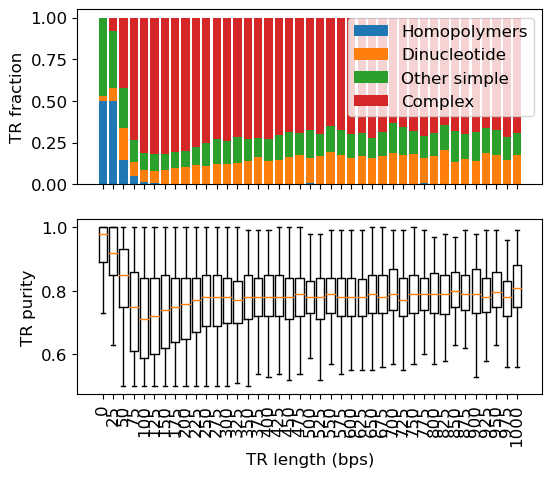

In [45]:
fig, (ax0, ax1) = plt.subplots(ncols=1, nrows=2, figsize=(6, 5), sharex=True)

xs = sorted(struct_by_len)

hom_ys = np.array([struct_by_len[x]["homs"] / struct_by_len[x]["total"] for x in xs])
ax0.bar(xs, hom_ys, width=20, label="Homopolymers")

dinuc_ys = np.array([struct_by_len[x]["dinucs"] / struct_by_len[x]["total"] for x in xs])
ax0.bar(xs, dinuc_ys, width=20, bottom=hom_ys, label="Dinucleotide")

simple_ys = np.array([struct_by_len[x]["other_simple"] / struct_by_len[x]["total"] for x in xs])
ax0.bar(xs, simple_ys, width=20, bottom=hom_ys + dinuc_ys, label="Other simple")

complex_ys = np.array([struct_by_len[x]["complex"] / struct_by_len[x]["total"] for x in xs])
ax0.bar(xs, complex_ys, width=20, bottom=hom_ys + dinuc_ys + simple_ys, label="Complex")
ax0.set_ylabel("TR fraction")
ax0.legend()

purity_vals = [purities_by_len[x] for x in xs]
ax1.boxplot(purity_vals, positions=xs, widths=20, showfliers=False)
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_xlabel("TR length (bps)")
ax1.set_ylabel("TR purity")
#plt.savefig("struc_purity_by_len.pdf")

## Estimate of how much TR variation we expect to see per genome

In [86]:
sample_to_deltas = {}

for rec in get_vcf_rec(joint_vcf):
    if rec.trid not in consistent_trids:
        continue
    ref_len = rec.locus.end - rec.locus.start
    for sample, gt in rec.gts.items():
        if sample not in sample_to_deltas:
            sample_to_deltas[sample] = {"ins": 0, "del": 0}
        for allele in gt:
            delta = len(allele.seq) - ref_len
            if delta > 0:
                sample_to_deltas[sample]["ins"] += delta
            if delta < 0:
                sample_to_deltas[sample]["del"] += abs(delta)

In [95]:
inses = []
dels = []
for sample, deltas in sample_to_deltas.items():
    total_ins = deltas["ins"] / (10**6)
    total_del = deltas["del"] / (10**6)
    inses.append(total_ins)
    dels.append(total_del)
    print(sample, total_ins, total_del)

NA12877 2.498222 1.445521
NA12878 2.506301 1.448374
NA12879 2.535279 1.460462
NA12881 2.539232 1.462342
NA12882 2.427701 1.445201
NA12883 2.447746 1.435449
NA12884 2.463244 1.427675
NA12885 2.459275 1.45763
NA12886 2.426179 1.443535
NA12887 2.530424 1.467992


In [96]:
np.mean(inses)

2.4833603

In [97]:
np.mean(dels)

1.4494181000000002

## Generate a karyoplot

Here we just generate a BED file that will be visualized with `karyoploteR` R package. See the script `karyoplot.R`.

In [107]:
with open("output/consistent_trs.bed", "w") as cons_file, open("output/inconsistent_trs.bed", "w") as incons_file:
    for rec in get_summary_rec():
        file = cons_file if rec.is_consistent else incons_file
        print(f"{rec.locus.chrom}\t{rec.locus.start}\t{rec.locus.end}\t{rec.trid}", file=file)

In [108]:
! wc -l output/consistent_trs.bed output/inconsistent_trs.bed

  523278 output/consistent_trs.bed
  127332 output/inconsistent_trs.bed
  650610 total
